In this recipe, we'll work with a myoglobin/hemoglobin mulitple sequence alignment to create and view a visual summary of the alignment, and then to apply some filtering of sequences and positions in the alignment. Because by definition a mutliple sequence alignment contains sequences all of the same length, an alignment can be thought of as matrix. A convenient way to get a visual summary of an alignment is with a heatmap. We're going to use the scikit-bio [``Alignment``](http://scikit-bio.org/docs/latest/generated/skbio.alignment.Alignment.html) object for this, along with some information from the [AAIndex database](http://www.genome.jp/aaindex/), and [matplotlib](http://matplotlib.org/).

First we'll prepare the environment with some imports, and by loading a pre-existing multiple sequence alignment into an ``Alignment``.

In [ ]:
from skbio import Alignment, ProteinSequence

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

aln = Alignment.read('data/globin-aln.fasta', constructor=ProteinSequence)

Next we're going to load the [AAIndex database](http://www.genome.jp/aaindex/) [hydrophobicity index values](http://www.genome.jp/dbget-bin/www_bget?aaindex:ARGP820101). This provides a measure of the hydrophobicity of all of the amino acids, where low values are associated with more hydrophilic amino acids, and high values are associated with more hydrophobic amino acids. We're going to use these in our visualization of the alignment.

In [2]:
# Data derived from AAIndex:
# http://www.genome.jp/dbget-bin/www_bget?aaindex:ARGP820101
from collections import defaultdict
hydrophobicity_idx = defaultdict(lambda: np.nan)
hydrophobicity_idx.update({'A': 0.61, 'L': 1.53, 'R': 0.60, 'K': 1.15, 'N': 0.06, 'M': 1.18, 
                           'D': 0.46, 'F': 2.02, 'C': 1.07, 'P': 1.95, 'Q': 0., 'S': 0.05, 
                           'E': 0.47, 'T': 0.05, 'G': 0.07, 'W': 2.65, 'H': 0.61, 'Y': 1.88, 
                           'I': 2.22, 'V': 1.32})
hydrophobicity_labels=['Hydrophilic', 'Medium', 'Hydrophobic']

## Visualizing alignments

Next we'll define a function that makes use of matplotlib to generate a heatmap-style image of the alignment. In the future, this functionality will be part of the ``Alignment`` object itself as a ``plot`` method (you can track progress on this as part of [#685](https://github.com/biocore/scikit-bio/issues/685)). The heatmap and legend code was adapted from the matplotlib gallery example [here](http://matplotlib.org/examples/pylab_examples/colorbar_tick_labelling_demo.html).

In [3]:
def aln_to_heatmap(aln, value_map, legend_labels=['Low', 'Medium', 'High'], fig_size=(15,10), cmap='YlGn', sequence_order=None):
    """Plot the alignment as a heatmap
    
    Parameters
    ----------
    aln : skbio.Alignment
        The alignment to be plotted
    value_map : dict, collections.defaultdict
        Dictionary mapping characters in the alignment to values. KeyErrors are not
        caught, so all possible values should be in this dict, or it should be a 
        collections.defaultdict with can, for example, default to ``nan``.
    legend_labels : iterable, optional
        Labels for the min, median, and max values in the legend.
    fig_size : tuple, optional
        Size of figure in inches.
    cmap : matplotlib colormap, optional
        See here for choices: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
    sequence_order : iterable
        The order, from top-to-bottom, that the sequences should be plotted in.
    
    Raises
    ------
    KeyError
        If a character in ``aln`` is not in ``value_map``, and ``value_map`` is not a 
        ``collections.defaultdict``.
        
    """
    
    # cache the sequence length, count, and ids, to avoid multiple look-ups
    sequence_length = aln.sequence_length()
    sequence_count = aln.sequence_count()
    sequence_ids = aln.ids()
    sequence_order = sequence_order or sequence_ids
    values = list(value_map.values())
    
    # create an empty data matrix
    mtx = np.zeros((sequence_length, sequence_count))
    # fill the data matrix by iterating over the alignment and mapping
    # characters to values
    for i in range(sequence_length):
        for j, sequence_id in enumerate(sequence_order):
            aa = str(aln[sequence_id][i])
            mtx[i][j] = value_map[aa]
    
    # build the heatmap, this code derived from the Matplotlib Gallery
    # http://matplotlib.org/examples/pylab_examples/colorbar_tick_labelling_demo.html
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size)

    cax = ax.imshow(mtx.T, interpolation='nearest', cmap=cmap)

    # Add colorbar and define tick labels
    cbar = fig.colorbar(cax, 
                        ticks=[min(values), 
                               np.median(values),
                               max(values)],
                        orientation='horizontal')
    ax.set_yticks([0] + list(range(3, sequence_count - 3, 3)) + [sequence_count-1])
    ax.set_yticklabels(sequence_order)
    ax.set_xticks(range(sequence_length))
    ax.set_xticklabels(aln.majority_consensus(),size=7)
    cbar.ax.set_xticklabels(legend_labels)# horizontal colorbar

We can now use this function to visualize our alignment. Note that the human hemoglobin sequence, which is the top-most one, is clearly the most different. We can also clearly see that hydrophobicity is highly conserved, as is illustrated by vertical bands that are similar in color. Some select sequence identifiers are used on the y-axis as labels, and the x-axis is the majority consensus character (either an amino acid abbreviation or a gap character) at each position in the alignment.

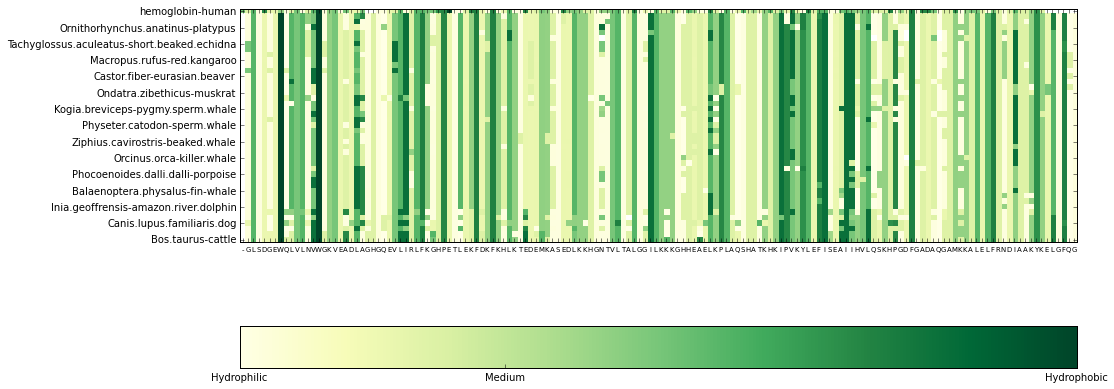

In [4]:
aln_to_heatmap(aln, hydrophobicity_idx, legend_labels=hydrophobicity_labels)

One limitation in the above plot is that there isn't any order to the sequences. If we want to vertically group sequences from more closely related organisms, we can build a neighbor joining tree fromt the alignment, perform outgroup rooting, and then traverse over the resulting tips to define the order.

In [5]:
from skbio.tree import nj
dm = aln.distances()
tree = nj(dm)
new_root = tree.find('hemoglobin-human').ancestors()[0]
outgroup_rooted_tree = tree.root_at(new_root)

In [6]:
sequence_order = [t.name for t in outgroup_rooted_tree.tips()]

We can then pass that order in, and we'll see that more similar organisms are now better grouped then they were above. Similarly, the vertical bands are now more consistent in color, since each pair of adjacent rows in the matrix are now from organisms that diverged from one another more recently.

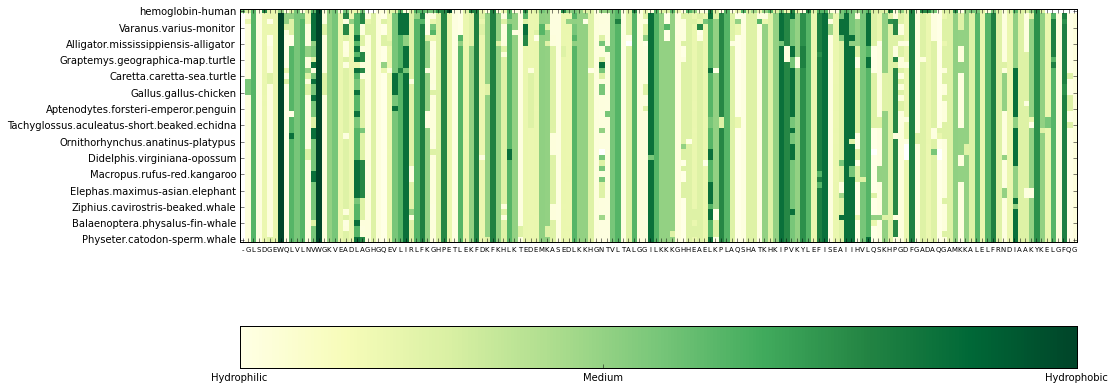

In [7]:
aln_to_heatmap(aln, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order)

## Filtering alignments

One very convenient feature of the ``Alignment`` object is the ability to create subalignments with [``Alignment.subalignment``](http://scikit-bio.org/docs/latest/generated/skbio.alignment.Alignment.subalignment.html#skbio.alignment.Alignment.subalignment). This allows selecting a subset of sequences, a subset of positions, or both from an ``Alignment``, and returns a new ``Alignment`` object.

For example, imagine you wanted to exclude the perfectly conserved and the least varaible positions in the alignment for a phylogenetic reconstruction process. You might want to do this because the most variable positions may be ones that are essentially unconserved, and therefore are only noise for the tree building process. The most perfectly conserved positions, on the other hand, don't contain any useful information about the relationships between the organisms, so can only increase the run time of phylogenetic reconstruction, but not improve the quality of the tree. We could do this by making use of ``Alignment.positional_entropies``, which will provide a measure of the amount of variation at some position in the alignment. Positional entropies are discussed in more detail in [the neighbor joining recipe](http://localhost:8888/notebooks/alignments-and-phylogenetic-reconstruction.ipynb). 

In [8]:
entropies = aln.position_entropies(base=21)
entropy_filtered_aln = aln.subalignment(positions_to_keep=[i for i, e in enumerate(entropies) if 0.0 < e <= 0.85])

After this process we have only 119 positions of our original 154 positions. We can visualize this to see that we no longer have any perfectly conserved positions, and the least conserved positions have also been filtered out.

In [9]:
entropy_filtered_aln

<Alignment: n=43; mean +/- std length=119.00 +/- 0.00>

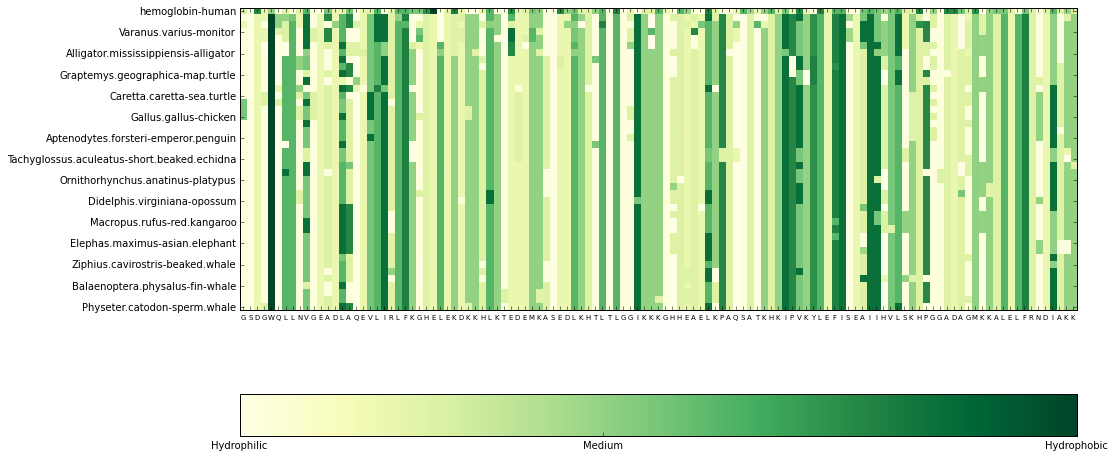

In [10]:
aln_to_heatmap(entropy_filtered_aln, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order)

We can also filter sequences from the alignment. For example, maybe we want to exclude our hemoglobin sequence, since it's a paralog of all of the other sequences in the alignment. We can do that by finding the name of the sequence (it's in our ``sequence_order`` list). Rather than have to pass all of the $n-1$ names of the sequences we want to keep, we can pass the name of the single sequence we want to exclude, and pass ``invert_seqs_to_keep=True``, which means keep all of the sequences except the ones provided in ``seqs_to_keep``.

In [11]:
myoglobin_aln = aln.subalignment(seqs_to_keep=['hemoglobin-human'], invert_seqs_to_keep=True)

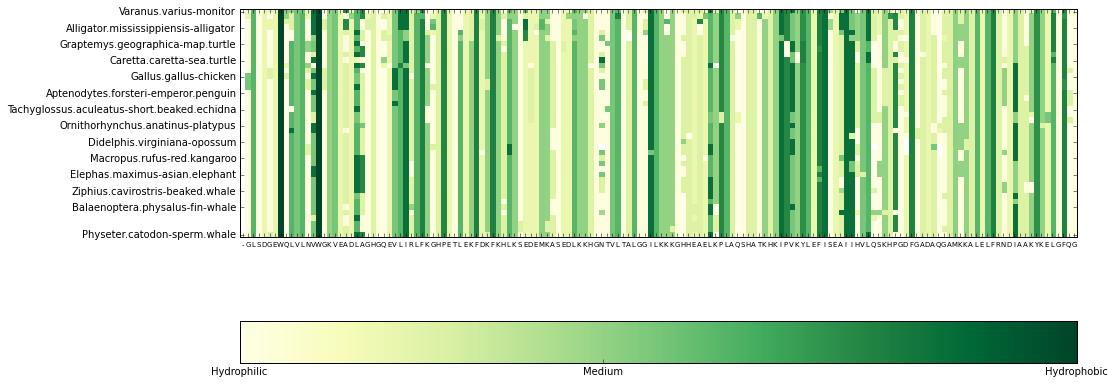

In [12]:
aln_to_heatmap(myoglobin_aln, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order[1:])

Similarly, if we want to keep only the sequences in some specific taxonomic group, we could identify those names and then pass them as ``seqs_to_keep`` without the invert option. Here we'll get the alignment of only the whale sequences.

In [13]:
whale_sequnece_ids = [e for e in sequence_order if e.endswith('whale')]
whale_aln = aln.subalignment(seqs_to_keep=whale_sequnece_ids)

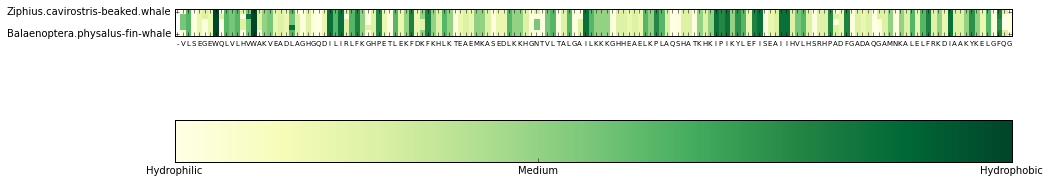

In [14]:
aln_to_heatmap(whale_aln, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=whale_sequnece_ids)